# Introduction
In this notebook, I describe my approach to solving the kaggle competition on predicting House Pricing (https://www.kaggle.com/c/home-data-for-ml-course). This is a regression problem where one needs to predict
the prices that actual houses were sold based on 79 features which are both categorical and numerical (both discrete and continuous).

References:  
https://www.kaggle.com/artyomkolas/housing-prices-nanpredct-featurselect-top-1
https://www.kaggle.com/angqx95/data-science-workflow-top-2-with-tuning
https://www.analyticsvidhya.com/blog/2016/01/guide-data-exploration/  
https://medium.com/cracking-the-data-science-interview/the-10-statistical-techniques-data-scientists-need-to-master-1ef6dbd531f7
https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/

# Table of Contents
1. [Understanding Data](#sec1)
    * [1.2 Univariate Analysis](#sec1.2)  
    * [1.3 Bi-variate Analysis](#sec1.3)  
2. [Data Preprocessing](#sec2)  
    * [2.1 Removing redundant features](#sec2.1)
    * [2.2 Dealing with Outliers](#sec2.2)
    * [2.3 Filling Missing Values](#sec2.3)
3. [Feature Engineering](#sec3)
4. [Modeling](#sec4)
    * [4.1 Scaling of features](#sec4.1)
    * [4.2 Ensemble Algorithms](#sec4.2)

In [871]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

<a id="sec1"></a>
# [1. Understanding Data](#sec1)

Let us start by exploring the dimension of our train and test sets and explore the first few lines of our train DataFrame.

In [872]:
train = pd.read_csv("/home/iris/Dropbox/Housing/train.csv", index_col=0)
test = pd.read_csv("/home/iris/Dropbox/Housing/test.csv", index_col=0)

print("train: ", train.shape)
print("test: ", test.shape)
train.head()

train:  (1460, 80)
test:  (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We can see that there are some columns that are filled with **NAN (Not a Number)**. We will investigate this later on and see how to deal with missing data, as this would be necessary in order to apply any ML algorithm.

In [873]:
X = pd.concat([train.drop("SalePrice", axis=1),test], axis=0)
y = train[['SalePrice']]

Let us have a look at what kind of data we have.

In [874]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

We see that we have both categorical and numerical data. Let us isolate the numerical and categorical columns since we will be applying different visualization techniques on them and different preprocessing will be requiered.

In [875]:
numeric_ = X.select_dtypes(exclude=['object']).copy()
numeric_.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

Next we make two groups of numerical columns the ones that take discrete values and the ones that take continuous.

In [876]:
disc_num_var = ['MSSubClass','OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

cont_num_var = []
for i in numeric_.columns:
    if i not in disc_num_var:
        cont_num_var.append(i)
print(cont_num_var)        

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


Next we make a dataframe where we gather the categorial columns

In [877]:
cat_train = X.select_dtypes(include=['object']).copy()
cat_train.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

Thus we have splitted our train set in categorical and numerical columns. The numerical columns have been splitted in two categories, one that take continuum values and one with discrete ones. Let us now start our data analysis by Univariate Analysis where only one variable is involved.

<a id="sec1.1"></a>
## [1.1 Univariate Analysis](#sec1.1)

### Numeric Features

For numerical features, we are always concerned about the **distribution** of these features, including the **statistical characteristics** of these columns e.g mean, median, mode. 

In [878]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


We will usually use **Distribution plot** to visualize the data distribution. These plots will also help us to identify outliers and features that take predominantly a single value. This information will be useful for the filtering that we will do during the preprocessing step.

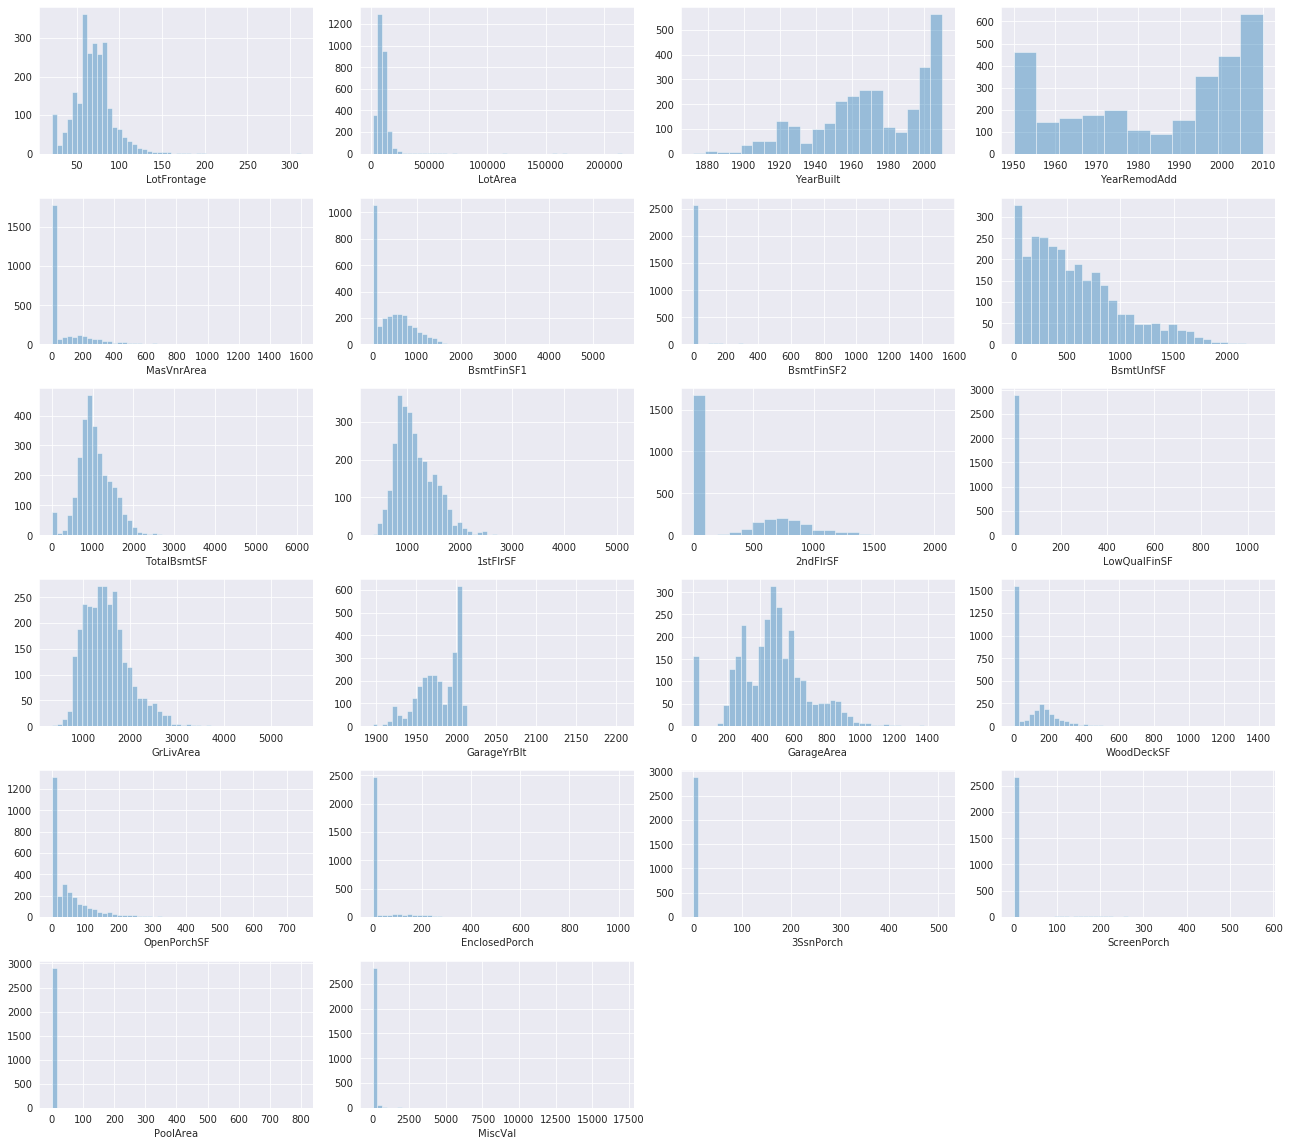

In [879]:
fig = plt.figure(figsize=(18,16))
for index,col in enumerate(cont_num_var):
    plt.subplot(6,4,index+1)
    sns.distplot(numeric_.loc[:,col], kde=False)
fig.tight_layout(pad=1.0)

Some of the Variables with mostly 1 value as seen from the plots above:
1. BsmtFinSF2
2. LowQualFinSF
3. EnclosedPorch
4. 3SsnPorch
5. ScreenPorch
6. PoolArea
7. MiscVal  

All these features are highly skewed, with mostly 0s and do not really add information for predicting Housing Price. Hence, we will remove them during our preprocessing step

 **Boxplots** are also commonly used to unearth the statistical characteristics of each feature. With boxplots we can easily identify outliers (plotted as individual points), the minimum and the maximum, Q1, Q2 and Q3.

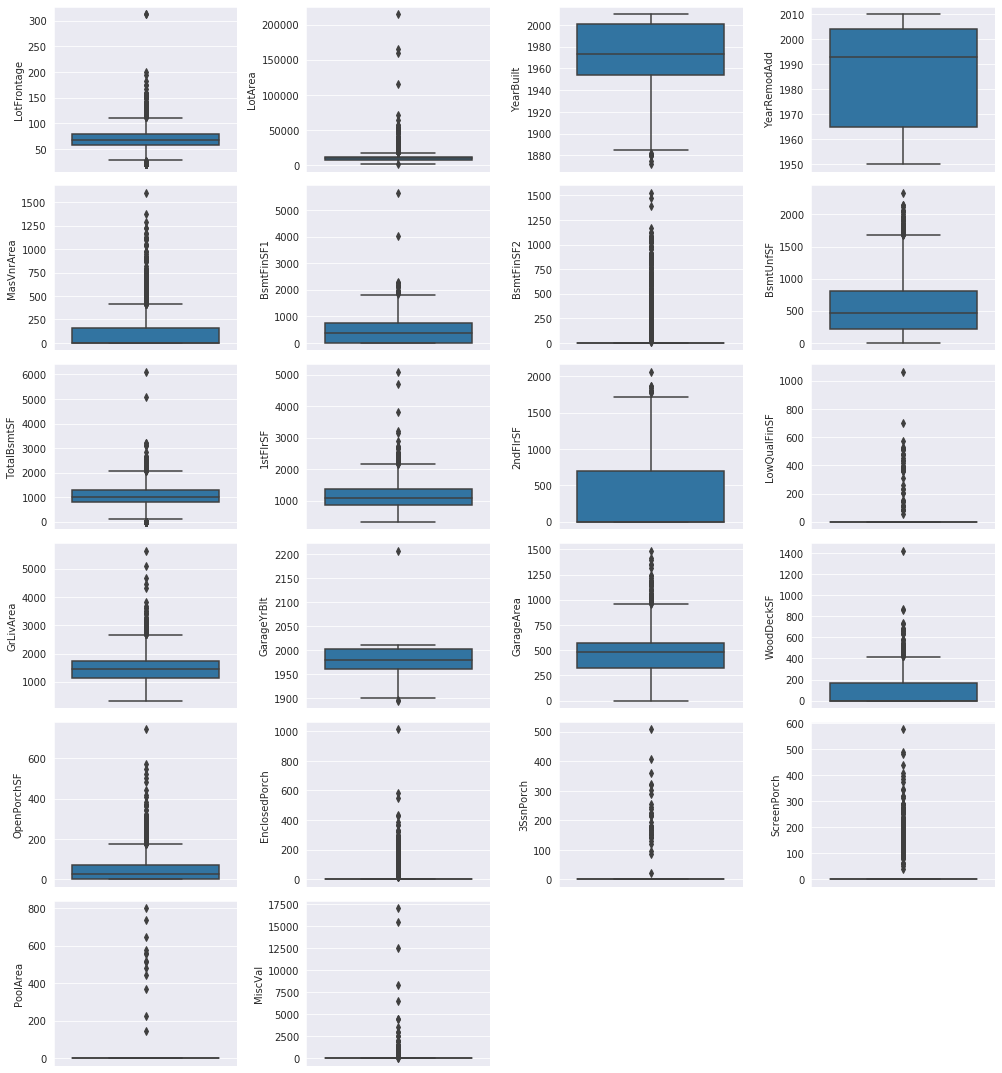

In [880]:
fig = plt.figure(figsize=(14,15))
for index,col in enumerate(cont_num_var):
    plt.subplot(6,4,index+1)
    sns.boxplot(y=col, data=numeric_)
fig.tight_layout(pad=1.0)

For the discrete numerical features we are going to use countplots as they give us a way to visualize how many instances of each discrete number we find in our dataset.

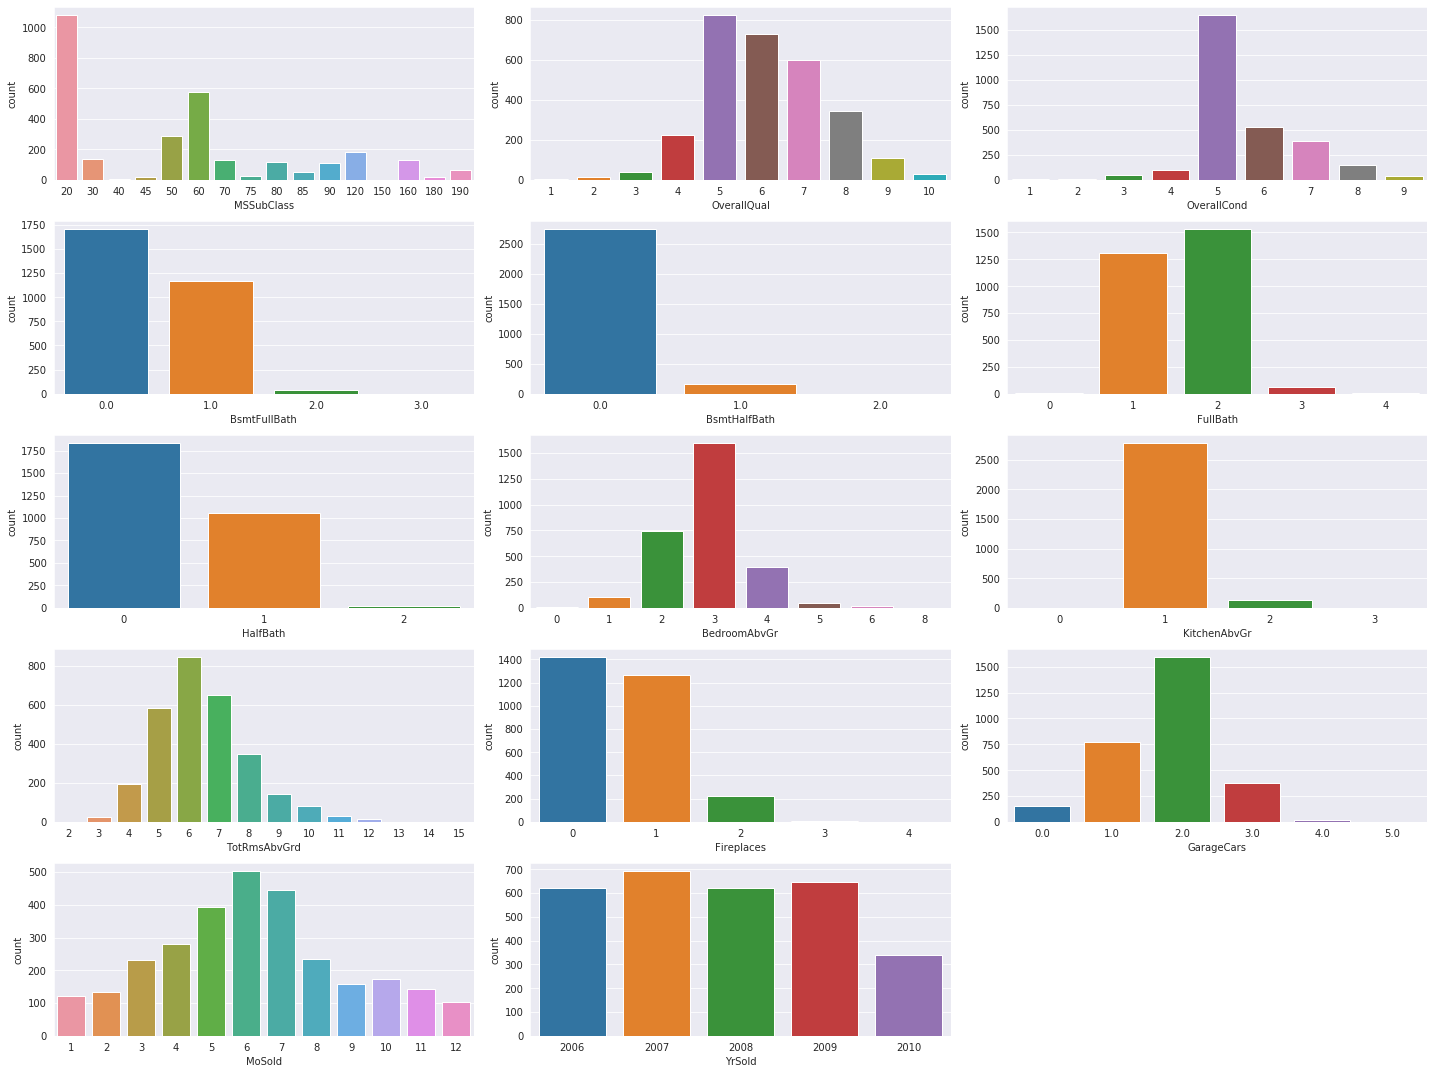

In [881]:
fig = plt.figure(figsize=(20,15))
for index,col in enumerate(disc_num_var):
    plt.subplot(5,3,index+1)
    sns.countplot(x=col, data=numeric_)
fig.tight_layout(pad=1.0)

We notice that the MSSubClass follows a distribution that is jumbled up. Thus we would consider this variable instead of numerical as categorical. 

In [882]:
disc_num_var.remove('MSSubClass')
numeric_ = numeric_.drop(['MSSubClass'], axis=1, inplace=True)
cat_train['MSSubClass'] = X['MSSubClass'] 

### Categorical Features

In the case of categorical features, we will often use countplots to visualize the count of each distinct value within each features. We can see that some categorical features like **Utilities, Condition2** consist of mainly just one value, which does not add any useful information. Thus, we will also remove them later on during preprocessing.

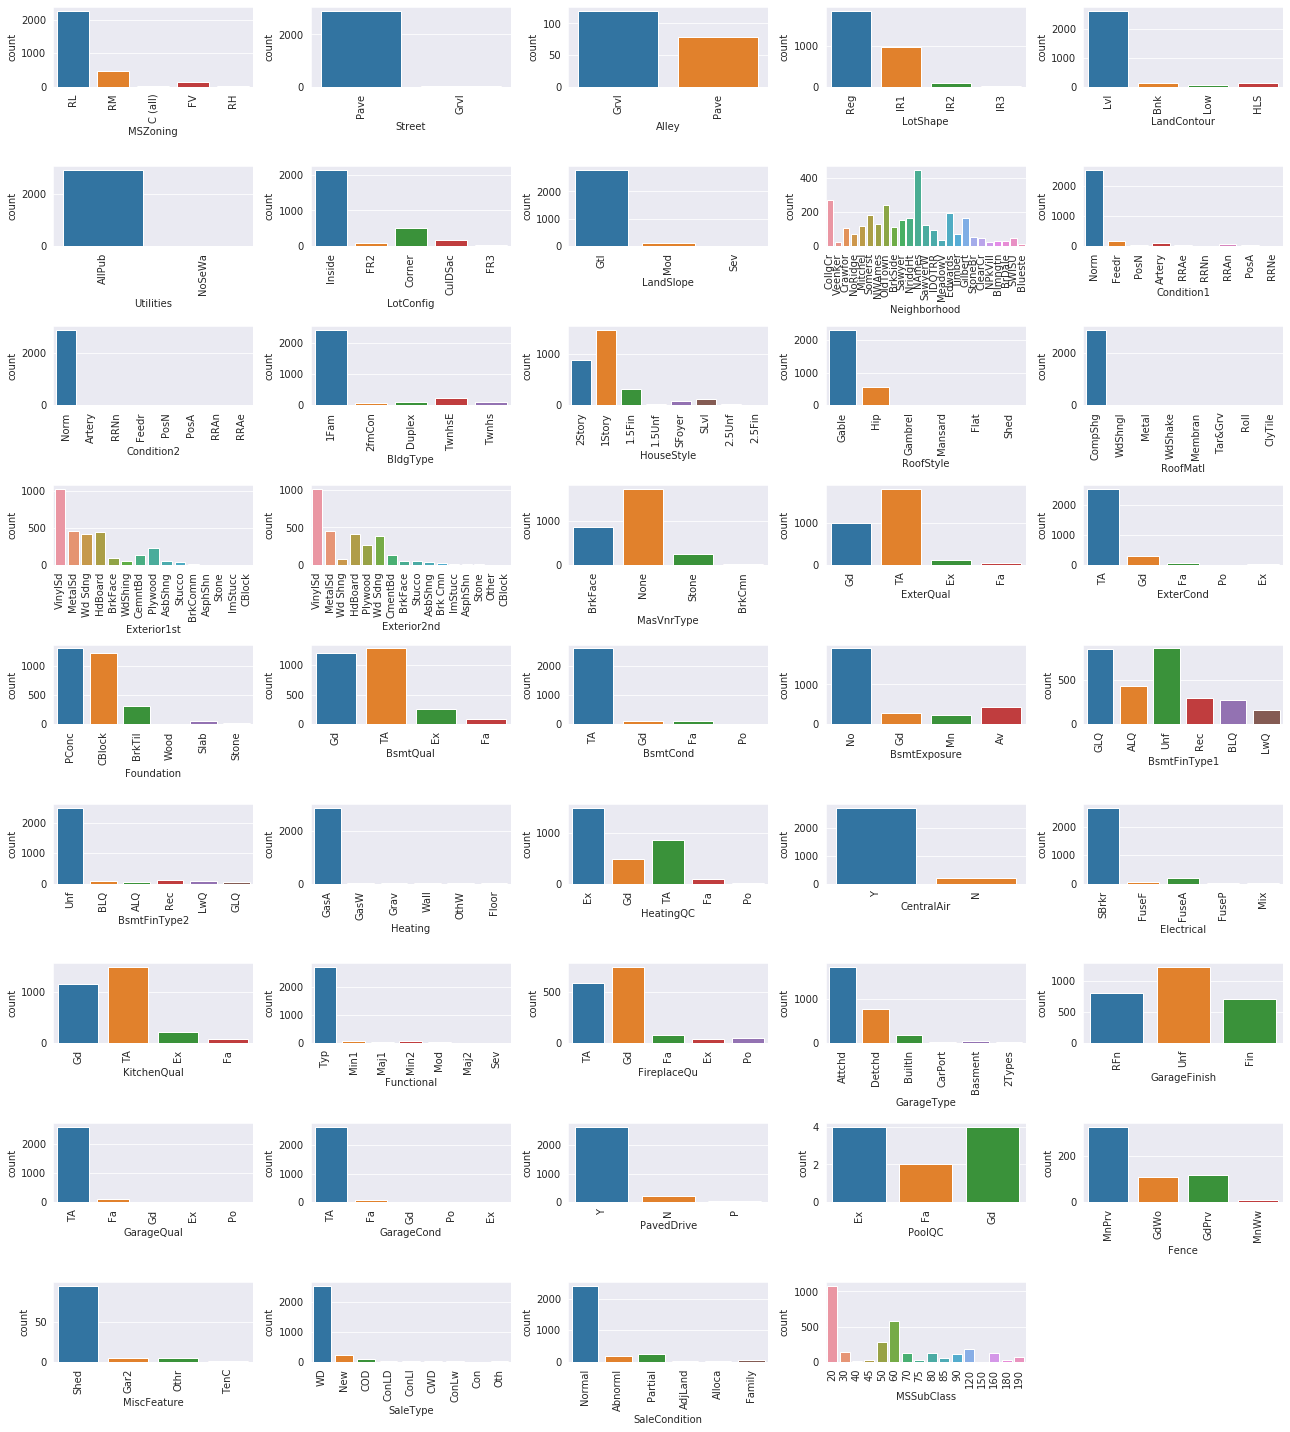

In [883]:
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_train.columns)):
    plt.subplot(9,5,index+1)
    sns.countplot(x=cat_train.iloc[:,index], data=cat_train)
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

Univariate Analysis helps us to understand all the features better, on an individual scale. To further deepen our insights and uncover potential pattern in the data, we will also need to find out more about the relationship between all these features with one another, which brings us to our next step in our analysis - Bivariate Analysis

<a id='sec1.2'></a>
## [1.2 Bi-Variate Analysis](#sec1.2)

Bi-variate analysis looks at 2 different features to identify any possible relationship or distinctive patterns between the 2 features. One of the commonly used technique is through the  **Correlation Matrix**. Correlation matrix is an effective tool to uncover linear relationship (Correlation) between any 2 continuous features. Correlation not only allow us to determine which features are important to Saleprice, but also as a mean to investigate any **multicollinearity** between our independent predictors.  
Multicollinearity happens when 2 or more independent variables are highly correlated with one another. In such situation, it causes precision loss in our regression coefficients, affecting our ability to identify the most important features that are most useful to our model. Thus when we find two features which show high correlation we are goinng to remove one of the two.

### Correlation Matrix

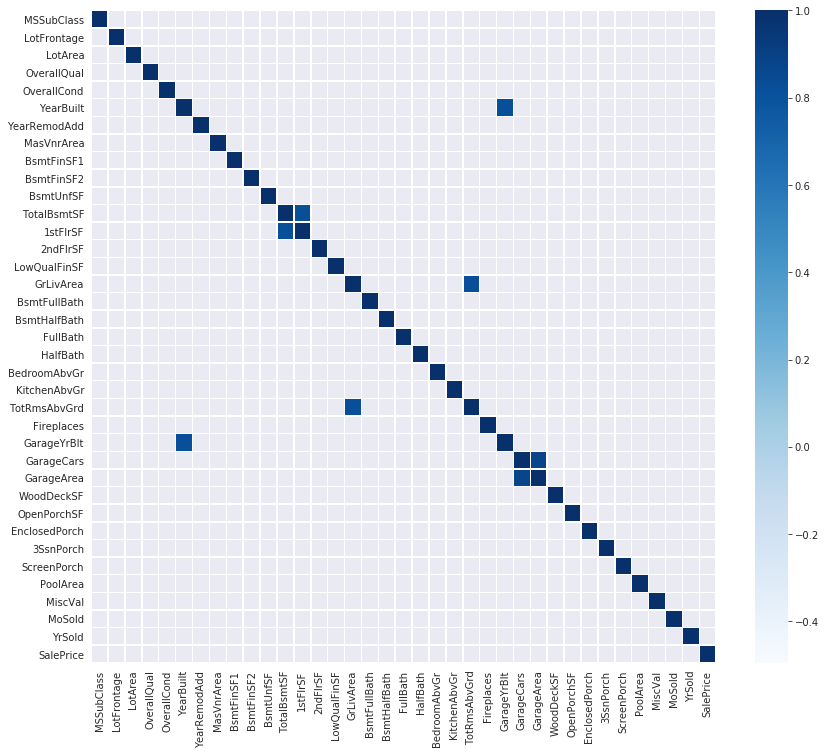

In [884]:
numeric_train = train.select_dtypes(exclude=['object']).copy()
plt.figure(figsize=(14,12))
correlation = numeric_train.corr()
sns.heatmap(correlation, mask = correlation <0.8, linewidth=0.5, cmap='Blues')

 **Highly Correlated variables**:
* GarageYrBlt and YearBuilt
* TotRmsAbvGrd and GrLivArea
* 1stFlrSF and TotalBsmtSF
* GarageArea and GarageCars

From the correlation matrix we have identified the above variables which are highly correlated with each other. This finding will guide us in our preprocessing steps later on as we aim to remove highly correlated features to avoid performance loss in our model

### Identifying relationship between Numerical Predictor and Target (*SalePrice*)
Below, we sorted the strength of linear relationship between Saleprice and other features. OverallQual and GrLivArea has the strongest linear relationship with SalePrice. Hence, these 2 features will be important factor in predicting Housing Price.

In [885]:
numeric_train = train.select_dtypes(exclude=['object'])
correlation = numeric_train.corr()
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


### Scatterplot
Using scatterplot can also help us to identify potential relationship between Numerical features. Although scatterplot does not provide quantitative evidence on the strength of linear relationship between our features, it is useful in helping us to visualize any sort of relationship that correlation matrix could not calculate. E.g Quadratic, Exponential relationships. 

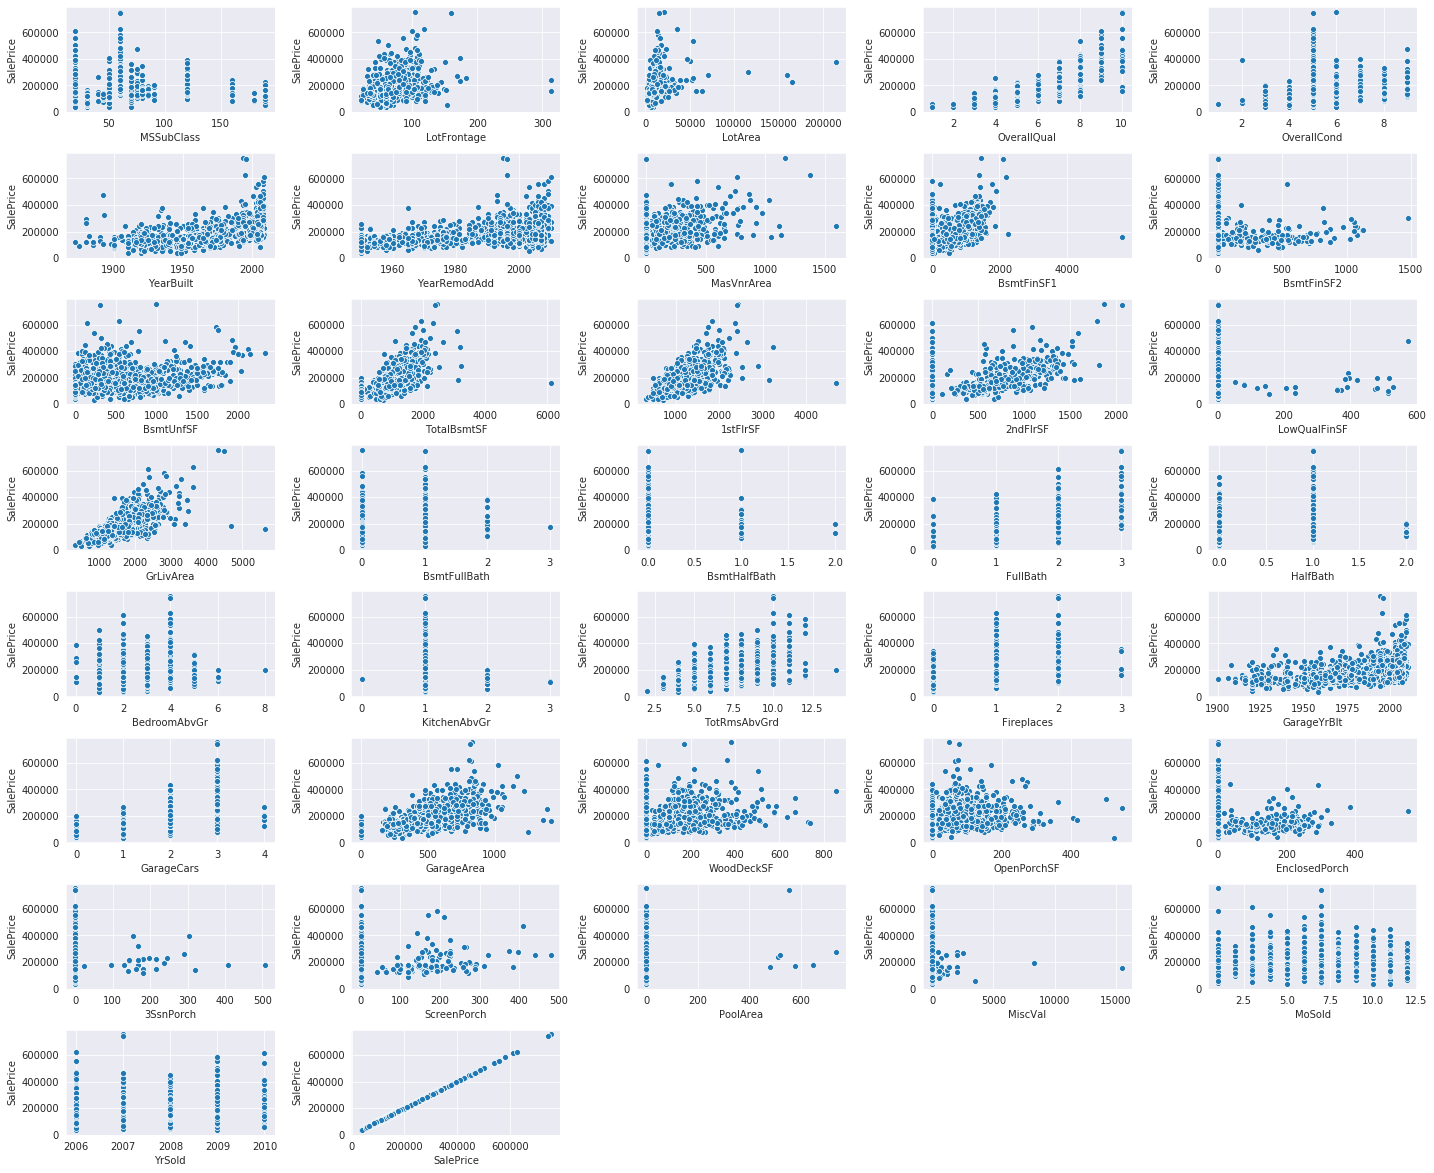

In [886]:
fig = plt.figure(figsize=(20,20))
for index in range(len(numeric_train.columns)):
    plt.subplot(10,5,index+1)
    sns.scatterplot(x=numeric_train.iloc[:,index], y='SalePrice', data=numeric_train)
fig.tight_layout(pad=1.0)

Having explored how each numerical feature affects the SalePrice we need to do a similar exploration for the categorical features. To this end, we calculate the mean value of SalePrice for all the unique entries of each categorical variable. We see here that many of the categorical variables take mainly only one value that's why the mean SalePrice with respect to other values is negligible. These features will not be useful to make predictions, but we will look more carefully to them before deciding which ones to drop. Some of the features have too many missing entries so the mean is also there negligible for all features.

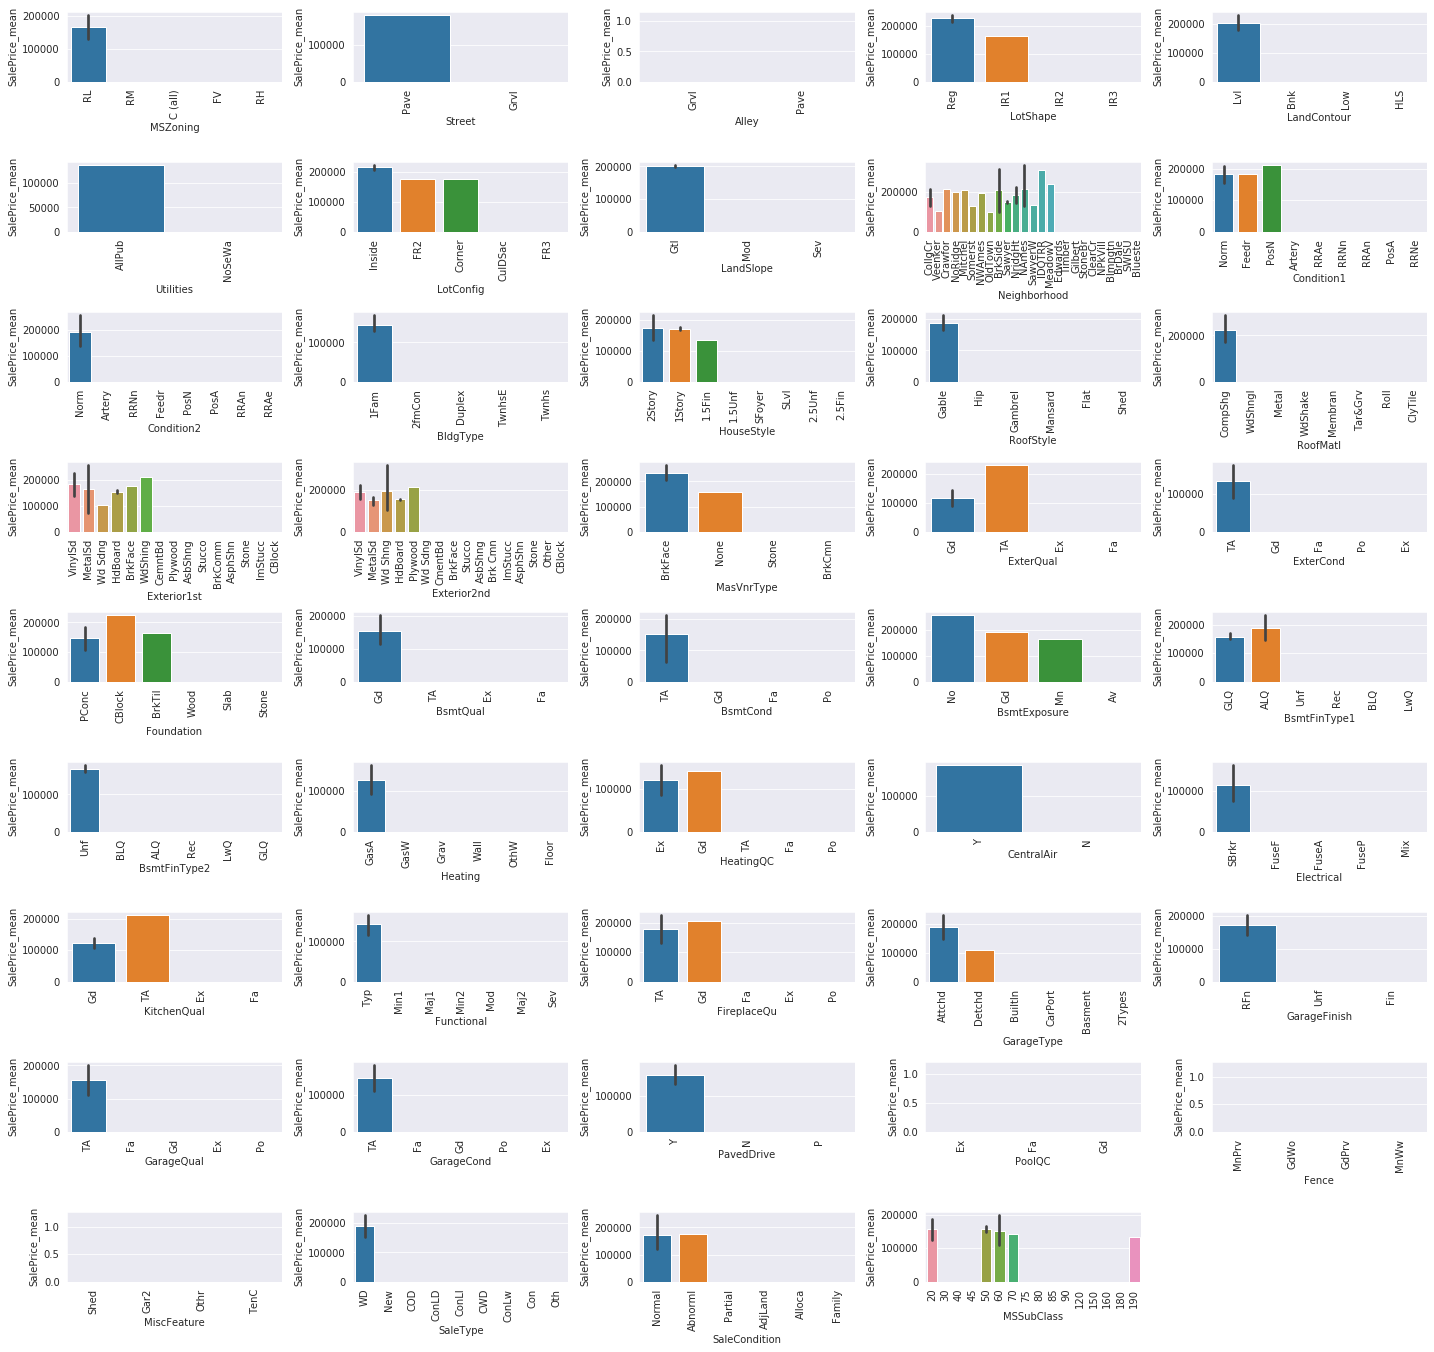

In [887]:
fig = plt.figure(figsize=(20,20))
ii = 0

for index in cat_train.columns:
        SalePrice_cat = train.groupby(index)['SalePrice'].mean().reset_index(name='SalePrice_mean')
        plt.subplot(10,5,ii+1)
        sns.barplot(x=cat_train.iloc[:,ii], y='SalePrice_mean', data=SalePrice_cat)
        ii += 1
        plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)     

<a id = 'sec2'></a>
# [2. Data Processing](#sec2)

Now that we have gained insights through the various analysis and visualization of our data we use them to guide our preprocessing decision. In this way we can provide clean, error-free, properly selected data for our model to train on later on.  

This section outlines the steps for Data Processing:
1. Removing Redundant Features
2. Dealing with Outliers
3. Filling in missing values

<a id="sec2.1"></a>
## [2.1 Removing Redundant Features](#sec2.1)

### Features with multicollinearity

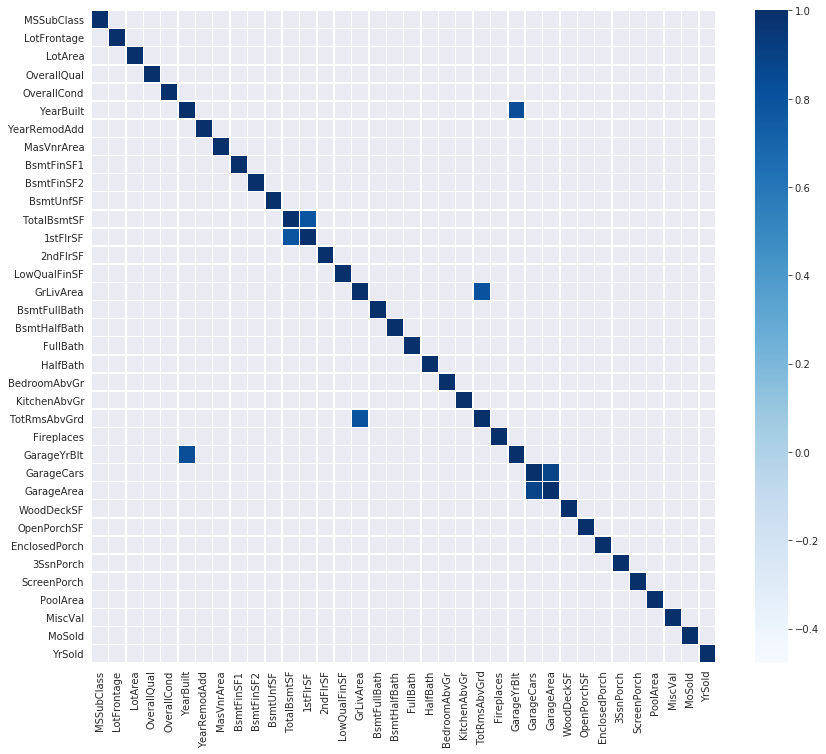

In [888]:
plt.figure(figsize=(14,12))
correlation = X.select_dtypes(exclude=['object']).corr()
sns.heatmap(correlation, mask = correlation <0.8, linewidth=0.5, cmap='Blues')

From the above correlation matrix, we have pinpointed certain features that are highly correlated
* GarageYrBlt and YearBuilt
* TotRmsAbvGrd and GrLivArea
* 1stFlrSF and TotalBsmtSF
* GarageArea and GarageCars

We will remove the highly correlated features to avoid the problem of multicollinearity.

In [889]:
X.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars'], axis=1, inplace=True)
#X.drop(['GarageYrBlt','TotRmsAbvGrd','GarageCars'], axis=1, inplace=True)

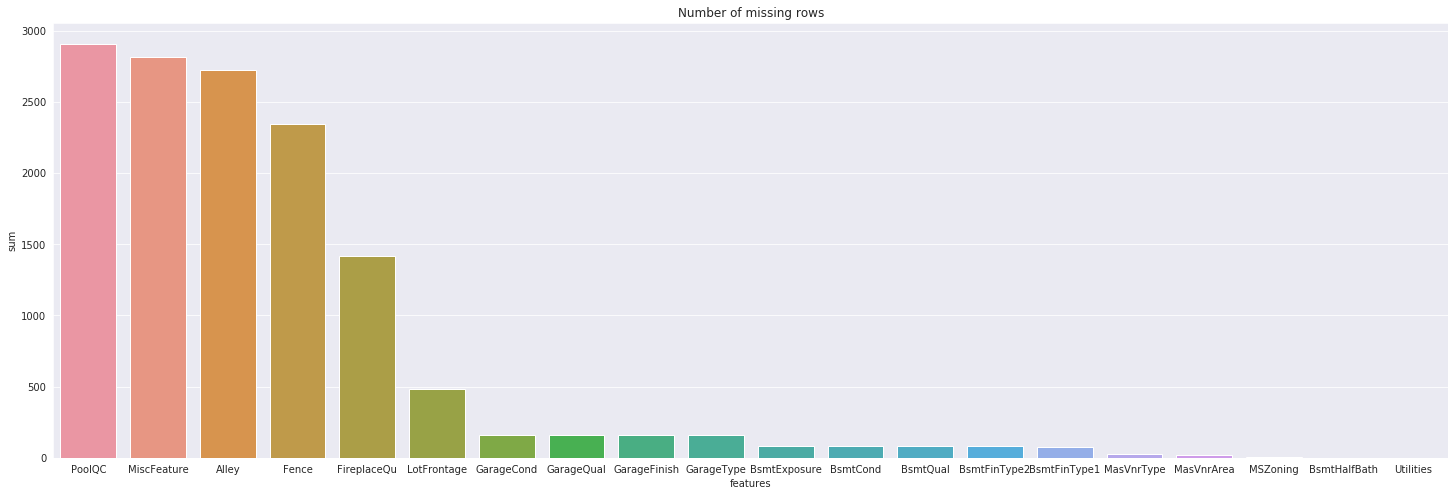

In [890]:
plt.figure(figsize=(25,8))
plt.title('Number of missing rows')
missing_count = pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(20).reset_index()
missing_count.columns = ['features','sum']
sns.barplot(x='features',y='sum', data = missing_count)


In [891]:
def NaN_info(df):
    global null_view
    try:
        null_view = df[[col for col in df.columns if df[col].isna().sum() > 0]].isna().sum().sort_values(ascending = False)
        null_view = pd.DataFrame(null_view, columns=['NANs'])
        null_view[['PERCENT']] = null_view[['NANs']].apply(lambda x: round((x/len(df))*100, 2))
        null_view[['TYPE']] = df.dtypes
    except:
        return null_view
    return null_view

NaN_info(X)

,NANs,PERCENT
PoolQC,2909,99.66
MiscFeature,2814,96.40
Alley,2721,93.22
Fence,2348,80.44
FireplaceQu,1420,48.65
LotFrontage,486,16.65
GarageCond,159,5.45
GarageQual,159,5.45
GarageFinish,159,5.45
GarageType,157,5.38


### Features with a lot of missing values
Apart from these highly correlated features, we will also remove features that are not very useful in prediction due to many missing values. PoolQC, MiscFeature, Alley,Fence have too many missing values to provide any useful information

In [892]:
#X.drop(['PoolQC','MiscFeature','Alley','Fence',], axis=1, inplace=True)

### Useless features in predicting SalePrice
We will also remove features that do not have any linear relationship with target *SalePrice*. To this end we will check all the features that had absolute value of correlation smaller than 0.05.

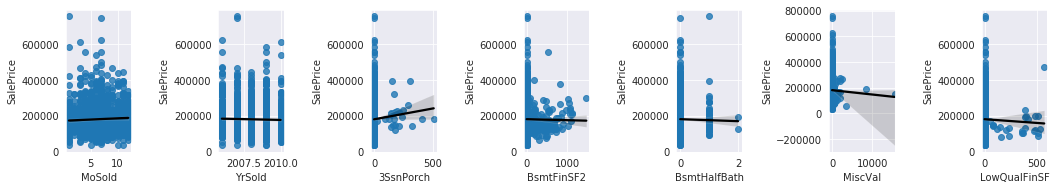

In [893]:
fig,axes = plt.subplots(1,7, figsize=(15,3))
sns.regplot(x=numeric_train['MoSold'], y='SalePrice', data=numeric_train, ax = axes[0], line_kws={'color':'black'})
sns.regplot(x=numeric_train['YrSold'], y='SalePrice', data=numeric_train, ax = axes[1],line_kws={'color':'black'})
sns.regplot(x=numeric_train['3SsnPorch'], y='SalePrice', data=numeric_train, ax = axes[2],line_kws={'color':'black'})
sns.regplot(x=numeric_train['BsmtFinSF2'], y='SalePrice', data=numeric_train, ax = axes[3],line_kws={'color':'black'})
sns.regplot(x=numeric_train['BsmtHalfBath'], y='SalePrice', data=numeric_train, ax = axes[4], line_kws={'color':'black'})
sns.regplot(x=numeric_train['MiscVal'], y='SalePrice', data=numeric_train, ax = axes[5],line_kws={'color':'black'})
sns.regplot(x=numeric_train['LowQualFinSF'], y='SalePrice', data=numeric_train, ax = axes[6],line_kws={'color':'black'})

fig.tight_layout(pad=2.0)

It seems that 'MoSold','YrSold','3SsnPorch','BsmtFinSF2','BsmtHalfBath','MiscVal','LowQualFinSF'exhibit no linear relation to SalePrice, this is why we will remove them as we do not expect that these features will help us to perform any predictions.

In [894]:
X.drop(['MoSold','YrSold','3SsnPorch','BsmtFinSF2','BsmtHalfBath','MiscVal','LowQualFinSF'], axis=1, inplace=True)

### Removing features that have mostly just 1 value

Earlier during our Univariate analysis, we found that some features mostly consist of just a single value or 0s, which is not useful to us. Therefore, we set a user defined threshold at 95%. If a column has more than 95% of the same value, we will render the features to be useless and remove it, since there isnt much information we can extract from

In [895]:
cat_col = X.select_dtypes(include=['object']).columns
overfit_cat = []
for i in cat_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 95:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)
#X = X.drop(overfit_cat, axis=1)

In [896]:
num_col = X.select_dtypes(exclude=['object']).columns
overfit_num = []
for i in num_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 95:
        overfit_num.append(i)

overfit_num = list(overfit_num)
#X = X.drop(overfit_num, axis=1)


In [897]:
print("Categorical Features with >95% of the same value: ",overfit_cat)
print("Numerical Features with >95% of the same value: ",overfit_num)

Categorical Features with >95% of the same value:  ['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'Heating']
Numerical Features with >95% of the same value:  ['KitchenAbvGr', 'PoolArea']


<a id="sec2.2"></a>
## [2.2 Dealing with Outliers](#sec2.2)

Removing outliers will prevent our models performance from being affected by extreme values.  
From our boxplot earlier, we have pinpointed the following features with extreme outliers:
* LotFrontage
* LotArea
* BsmtFinSF1
* TotalBsmtSF
* GrLivArea

We will remove the outliers based on certain threshold value.

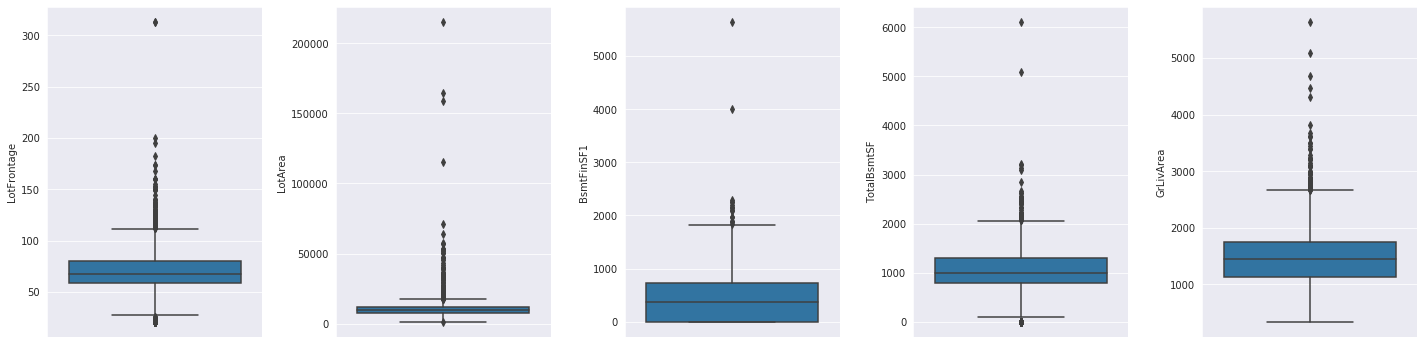

In [898]:
out_col = ['LotFrontage','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea']
fig = plt.figure(figsize=(20,5))
for index,col in enumerate(out_col):
    plt.subplot(1,5,index+1)
    sns.boxplot(y=col, data=X)
fig.tight_layout(pad=1.5)

In [899]:
train = train.drop(train[train['LotFrontage'] > 250].index)
train = train.drop(train[train['LotArea'] > 100000].index)
train = train.drop(train[train['BsmtFinSF1'] > 3000].index)
train = train.drop(train[train['TotalBsmtSF'] > 5000].index)
train = train.drop(train[train['GrLivArea'] > 4000].index)

<a id="sec2.3"></a>
## [2.3 Filling Missing Values](#sec2.3)

Our machine learning model is unable to deal with missing values, thus we need to deal with them based on our understanding of the features. These missing values are denoted **NAN** as we have seen earlier during our data exploration.

In [900]:
pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(26)

,sum
PoolQC,2909
MiscFeature,2814
Alley,2721
Fence,2348
FireplaceQu,1420
LotFrontage,486
GarageFinish,159
GarageCond,159
GarageQual,159
GarageType,157


## Nominal Features


We will replace the missing value of our categorical features with the most frequent occurrence (mode) of the individual features in a specific Neighborhood.

In [901]:
#categorical
cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
X[cols] = X.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()[0]))

### Numerical features
For **Numerical Features**, the common approach will be to replace the missing value with the mean of the feature distribution.  
However, certain features like *LotFrontage* and *GarageArea* have wide variance in their distribution. Taking mean values across *Neighborhoods*, we will see that the mean varies alot from just taking the mean value of these individual column, since each neightborhood have different LotFrontage and GarageArea mean value. Hence, i decided to group these features by Neighborhoods to impute the respective mean values.

In [902]:
print("Mean of LotFrontage: ", X['LotFrontage'].mean())
print("Mean of GarageArea: ", X['GarageArea'].mean())

Mean of LotFrontage:  69.30579531442663
Mean of GarageArea:  472.8745716244003


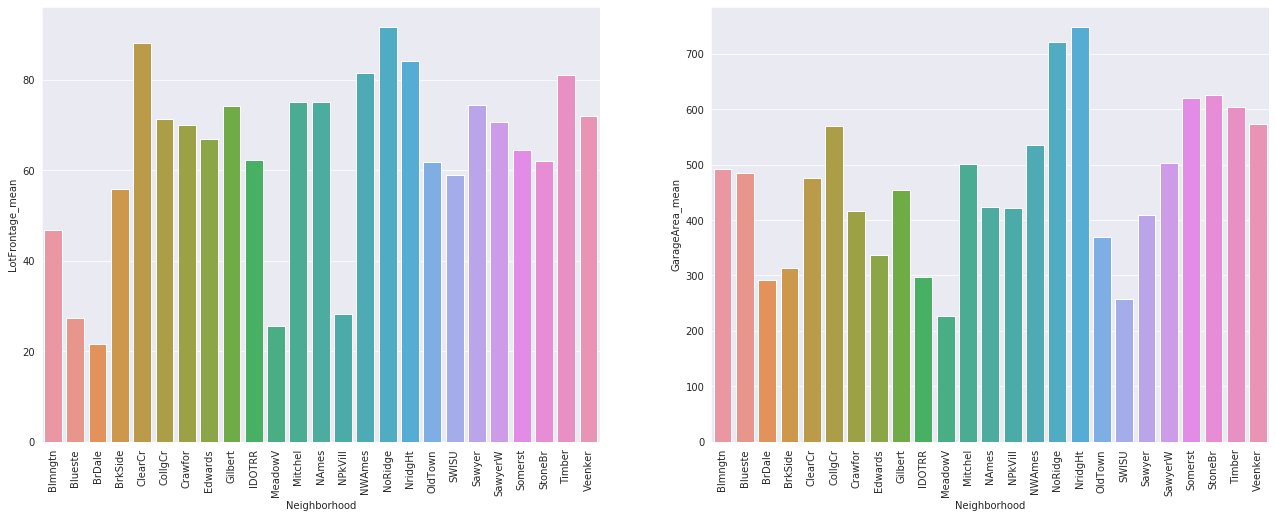

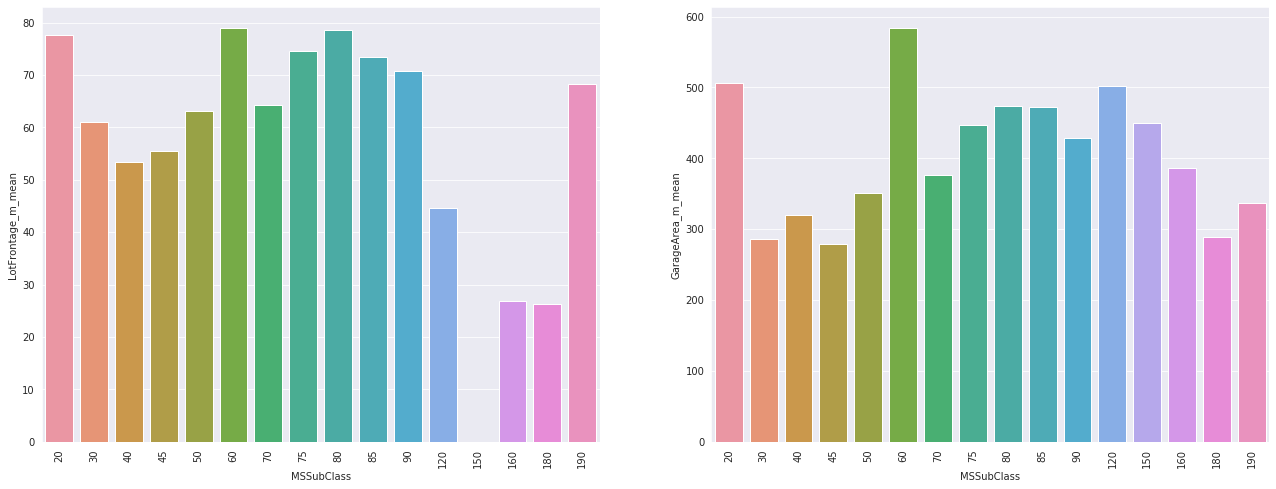

In [903]:
neigh_lot = X.groupby('Neighborhood')['LotFrontage'].mean().reset_index(name='LotFrontage_mean')
neigh_garage = X.groupby('Neighborhood')['GarageArea'].mean().reset_index(name='GarageArea_mean')
mssub_lot = X.groupby('MSSubClass')['LotFrontage'].mean().reset_index(name='LotFrontage_m_mean')
mssub_garage = X.groupby('MSSubClass')['GarageArea'].mean().reset_index(name='GarageArea_m_mean')


fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='LotFrontage_mean', data=neigh_lot, ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='GarageArea_mean', data=neigh_garage, ax=axes[1])
fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.barplot(x='MSSubClass', y='LotFrontage_m_mean', data=mssub_lot, ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.barplot(x='MSSubClass', y='GarageArea_m_mean', data=mssub_garage, ax=axes[1])


In [904]:
#for correlated numeircal continuous features mean in certain Neighboorhood
X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
X['GarageArea'] = X.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))

#numerical continuous
cont = ["BsmtFinSF1", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea"]
X[cont] = X[cont].fillna(X[cont].mean())

#numerical discrete we use median instead of mean as mean would give us floats instead of integers
X['BsmtFullBath'] = X['BsmtFullBath'].fillna(X['BsmtFullBath'].median())

#### Changing Data Type
Since **MSSubClass** is an integer column based on some mapped values in string notation, we change its data type to string value instead

In [905]:
X['MSSubClass'] = X['MSSubClass'].apply(str)

### Mapping Ordinal Features
There are some columns which are ordinal by nature, which represents the quality or condition of certain housing features. In this case, we will map the respective strings to a value. The better the quality, the higher the value. After this transformation we apply(int) to the corresponding columns so that pandas can identify that these are now numerical columns.

### Ordinal features 
We will replace the rest of the categorical missing values with NA. For the ordinal categorical features which will be mapped later on when we encode them into an ordered arrangement the NA will be mapped to 0.

In [906]:
#cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
#       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu',"KitchenQual",
#       "HeatingQC",'ExterQual','ExterCond']
print(cat_col)

X[cat_col] = X[cat_col].fillna("NA")

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [907]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

In [908]:
ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual',\
           'GarageQual','GarageCond', 'FireplaceQu']
for col in ord_col:
    X[col] = X[col].map(ordinal_map).apply(int)
    X[col] 
    
fin_col = ['BsmtFinType1','BsmtFinType2']
for col in fin_col:
    X[col] = X[col].map(fintype_map).apply(int)

X['BsmtExposure'] = X['BsmtExposure'].map(expose_map).apply(int)

After converting our categorical features to ordinal we check the correlation matrix again. We see that 
FirePlaces and FirePlaceQu are highly correlated. Since in the FirePlaceQu we had originally many missing entries
we will choose to remove this column. High correlation appears also between GarageQual and GarageCond. There we
had the same number of missing values originally so it does not make much difference which one we choose to remove.

### Converting Categorical to Numerical
Lastly, because machine learning only learns from data that is numerical in nature, we will convert the remaining categorical columns into numerical features to feed them into our ML algorithm. Let us see which columns are still categorical.

In [909]:
cat_feat=X.select_dtypes(include=['object']).columns

In [910]:
print(cat_feat)

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
       'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
       'SaleCondition'],
      dtype='object')


Next we move to perform Target Encoding. In Target Encoding a categorical value is substituted with the mean value of the target variable for this specific categorical variable in the training set. We follow this approach as one-hot encoding would create a lot of extra columns and would increase considerably the computational cost of our model. We fit only on the training set in order not to have data leakage. For this method we would have also not other option as for the test set we do not know the target value. However, we could have used other options like Label Encoding and test the best one in a cross validation set.

In [911]:
import category_encoders as ce

target_enc = ce.TargetEncoder(cols=cat_feat)
target_enc.fit(X.select_dtypes(['object']).loc[train.index], y.loc[train.index])

# Transform the features, rename the columns with _target suffix, and join to dataframe
X_TE = X.select_dtypes(exclude=['object']).join(target_enc.transform(X[cat_feat]).add_suffix('_target'))

In [912]:
X_TE.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,Electrical_target,Functional_target,GarageType_target,GarageFinish_target,PavedDrive_target,PoolQC_target,Fence_target,MiscFeature_target,SaleType_target,SaleCondition_target
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,4,3,4,...,185612.745852,182230.895633,201196.822506,201562.054762,185238.035312,179642.652835,186722.435525,180981.774839,172043.79127,174255.292785
2,80.0,9600,6,8,1976,1976,0.0,3,3,4,...,185612.745852,182230.895633,201196.822506,201562.054762,185238.035312,179642.652835,186722.435525,180981.774839,172043.79127,174255.292785
3,68.0,11250,7,5,2001,2002,162.0,4,3,4,...,185612.745852,182230.895633,201196.822506,201562.054762,185238.035312,179642.652835,186722.435525,180981.774839,172043.79127,174255.292785
4,60.0,9550,7,5,1915,1970,0.0,3,3,3,...,185612.745852,182230.895633,134091.162791,141891.781457,185238.035312,179642.652835,186722.435525,180981.774839,172043.79127,140541.890000
5,84.0,14260,8,5,2000,2000,350.0,4,3,4,...,185612.745852,182230.895633,201196.822506,201562.054762,185238.035312,179642.652835,186722.435525,180981.774839,172043.79127,174255.292785


In [913]:
pd.DataFrame(X_TE.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(5)

,sum
LotFrontage,0
LotConfig_target,0
HouseStyle_target,0
BldgType_target,0
Condition2_target,0


We see that we still have two numerical features with missing values, which we would need to deal wih. GarageYrBlt has most likely this 159 missing entries as there is no Garage. Originally the same number of values was missing with other categorical features associated to the Garage. We would impute these 2 features by zero although it might have been a better strategy.

In [914]:
#X_TE['GarageYrBlt'] = X['GarageYrBlt'].apply(lambda x: 1 if x > 0 else 0)
#X_TE['GarageCars'] = X_TE['GarageCars'].fillna(0)

### SalePrice Distribution

Distribution is skewed to the right, where the tail on the curve’s right-hand side is longer than the tail on the left-hand side, and the mean is greater than the mode. This situation is also called positive skewness.  
Having a skewed target will affect the overall performance of our machine learning model, thus, one way to alleviate will be to using **log transformation** on skewed target, in our case, the *SalePrice* to reduce the skewness of the distribution. Indeed, by cross validation we have found that this makes a huge effect on the performance.

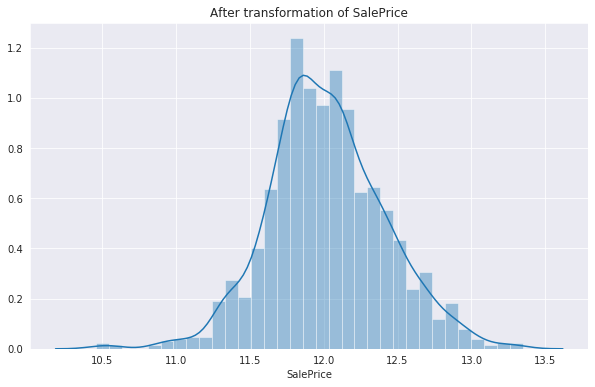

In [915]:
plt.figure(figsize=(10,6))
plt.title("After transformation of SalePrice")
dist = sns.distplot(np.log(train['SalePrice']),norm_hist=False)

In [916]:
y.loc[:,"SalePrice"] = y.loc[:,'SalePrice'].apply(np.log)

Now we have finished preprocessing our data and we can move to modelling.

# [4. Modeling](#sec4)
This section will consist of scaling the data for better optimization in our training, and also introducing the varieties of ensembling methods that are used in this notebook for predicting the Housing price. We also try out hyperparameter tuning briefly, as i will be dedicating a new notebook that will explain more in details on the process of Hyperparameter Tuning as well as the mathematical aspect of the ensemble algorithms.

### Now we have preprocessed the train and test data in the same way, so we split them in two groups.

In [917]:
x = X_TE.loc[train.index]
y = y.loc[train.index]
test = X_TE.loc[test.index]

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

## [4.1 Scaling of Data](#sec4.1)
**RobustScaler** is a transformation technique that removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). It is also robust to outliers, which makes it ideal for data where there are too many outliers that will drastically reduce the number of training data. 

In [918]:
from sklearn.preprocessing import RobustScaler

cols = x.select_dtypes(np.number).columns
transformer = RobustScaler().fit(x[cols])
x[cols] = transformer.transform(x[cols])
test[cols] = transformer.transform(test[cols])


<a id='sec4.2'></a>
## [4.2 Ensemble Algorithms](#sec4.2)

### Ensembling Models
Ensembling methods are meta-algorithms which involves combining several machine learning models into one predictive model, aim at decreasing variance(reduce overfitting) and improving bias(improve accuracy). We
are going to 


In [919]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn import ensemble
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

In [920]:

def find_optimal_xgb_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - The percentage of values that are the same in a  column
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        overfit_num = []
        for i in X.columns:
            counts = X[i].value_counts()
            zeros = counts.iloc[0]
            if zeros / len(X) * 100 > cutoff:
                overfit_num.append(i)

        overfit_num = list(overfit_num)
        reduce_X = X.drop(overfit_num, axis=1)

       # reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response

        xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')
        xgb.fit(X_train, y_train)
   
        y_test_preds = xgb.predict(X_test)
        y_train_preds = xgb.predict(X_train)

        #append the r2 value from the test set and the train set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)
    

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=0)
        plt.show()

    best_cutoff = max(results, key=results.get)
    
    

    #reduce X matrix

    for i in X.columns:
            counts = X[i].value_counts()
            zeros = counts.iloc[0]
            if zeros / len(X) * 100 > int(best_cutoff):
                overfit_num.append(i)

    overfit_num = list(overfit_num)
    reduce_X = X.drop(overfit_num, axis=1)
    num_feats.append(reduce_X.shape[1])
   

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model

    xgb.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, X_train, X_test, y_train, y_test

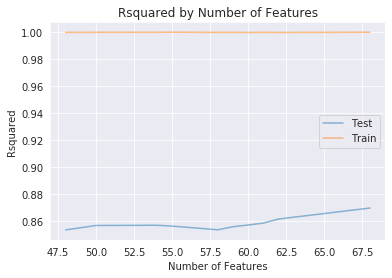

In [921]:
#cutoffs here pertains the percenage of same values allowed in one column
#Therefore, higher values for the cutoff provides more predictors in the model.
cutoffs = [ 100, 98, 97, 96, 95, 94, 93, 92, 90, 88]
#Run this cell to pass your X and y to the model for testing
r2_scores_test, r2_scores_train, X_train, X_val, y_train, y_val = find_optimal_xgb_mod(x, y, cutoffs)


#### XGBoost HyperParameter Tuning

In [922]:
from sklearn.model_selection import RandomizedSearchCV

#param_lst = {
#    'learning_rate' : [0.01, 0.1, 0.15],
#   'n_estimators' : [ 2000, 3000, 3500],
#    'max_depth' : [2, 3, 4],
#    'min_child_weight' : [1, 2, 3],
#    'reg_alpha' : [  0.01, 0.1, 0.2],
#    'reg_lambda' : [ 0.001, 0.01, 0.1]
#}

#lightgbm = RandomizedSearchCV(estimator = xgm, param_distributions = param_lst,
 #                              scoring = 'neg_root_mean_squared_error',
 #                             cv = 5)
       
#xgb_search = xgb_reg.fit(X_train, y_train)

# XGB with tune hyperparameters
#best_param = xgb_search.best_params_


best_param = {'reg_lambda': 0.01, 'reg_alpha': 0.1, 'n_estimators': 3500, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.01}

print(best_param)

xgb = XGBRegressor(**best_param)

{'reg_lambda': 0.01, 'reg_alpha': 0.1, 'n_estimators': 3500, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.01}


### LightGBM



#### LightBGM Hyperparameter tuning

In [923]:
lgbm = LGBMRegressor(boosting_type='gbdt',objective='regression')
#param_lst = {
#    'max_depth' : [1, 2, 3],
#    'learning_rate' : [0.001, 0.01, 0.1],
#    'n_estimators' : [300, 500, 800],
#    'lambda_l1' : [0.0001, 0.001, 0.05],
#    'lambda_l2' : [ 0.0001, 0.001, 0.01],
#    'feature_fraction' : [0.2, 0.3, 0.4],
#'min_child_samples' : [ 2, 3, 4]
#}

#lightgbm = RandomizedSearchCV(estimator = lgbm, param_distributions = param_lst,
#                               scoring = 'neg_root_mean_squared_error',
#                              cv = 5)
       
#lightgbm_search = lightgbm.fit(X_train, y_train)

# LightBGM with tuned hyperparameters
#best_param = lightgbm_search.best_params_

best_param={'n_estimators': 800, 'min_child_samples': 3, 'max_depth': 2, 'learning_rate': 0.1, 'lambda_l2': 0.0001, 'lambda_l1': 0.05, 'feature_fraction': 0.3}
print(best_param)

lgbm = LGBMRegressor(**best_param)

{'n_estimators': 800, 'min_child_samples': 3, 'max_depth': 2, 'learning_rate': 0.1, 'lambda_l2': 0.0001, 'lambda_l1': 0.05, 'feature_fraction': 0.3}


### Catboost


#### CatBoost Hyperparameter Tuning

In [924]:
cb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
#param_lst = {
#    'n_estimators' : [100, 300, 500, 1000, 1300, 1600],
#    'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
#    'l2_leaf_reg' : [0.001, 0.01, 0.1],
#    'random_strength' : [0.25, 0.5 ,1],
#    'max_depth' : [3, 6, 9],
#    'min_child_samples' : [2, 5, 10, 15, 20],
#    'rsm' : [0.5, 0.7, 0.9],
    
#}

#catboost = RandomizedSearchCV(estimator = cb, param_distributions = param_lst,
#                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
#                              cv = 5)

#catboost_search = catboost.fit(X_train, y_train)

# CatBoost with tuned hyperparams
#best_param = catboost_search.best_params_

best_param={'rsm': 0.5, 'random_strength': 1, 'n_estimators': 1000, 'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.1, 'l2_leaf_reg': 0.1}
print(best_param)
cb = CatBoostRegressor(logging_level='Silent', **best_param)

{'rsm': 0.5, 'random_strength': 1, 'n_estimators': 1000, 'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.1, 'l2_leaf_reg': 0.1}


In [925]:
#f_im = cb.feature_importances_.round(7)
#ser_rank = pd.Series(f_im[0:10],index=X.columns[0:10]).sort_values(ascending=False)


#fig, ax = plt.subplots(figsize=(20,10))
#sns.set_context("paper")
#sns.barplot(y=ser_rank.index,x=ser_rank.values,palette='deep')
#plt.xlabel('relative importance')
#plt.savefig('Features.png')

In [926]:
test = test[X_train.columns]
x = x[X_train.columns]

#### Training and Evaluation

In [927]:
def mean_cross_val(model, X, y):
    score = cross_val_score(model, X, y, cv=5)
    mean = score.mean()
    return mean

cb.fit(X_train, y_train)   
preds = cb.predict(X_val) 
preds_test_cb = cb.predict(test)
mae_cb = mean_absolute_error(y_val, preds)
rmse_cb = np.sqrt(mean_squared_error(y_val, preds))
score_cb = cb.score(X_val, y_val)
cv_cb = mean_cross_val(cb, x, y)


xgb.fit(X_train, y_train)   
preds = xgb.predict(X_val) 
preds_test_xgb = xgb.predict(test)
mae_xgb = mean_absolute_error(y_val, preds)
rmse_xgb = np.sqrt(mean_squared_error(y_val, preds))
score_xgb = xgb.score(X_val, y_val)
cv_xgb = mean_cross_val(xgb, x, y)


lgbm.fit(X_train, y_train)   
preds = lgbm.predict(X_val) 
preds_test_lgbm = lgbm.predict(test)
mae_lgbm = mean_absolute_error(y_val, preds)
rmse_lgbm = np.sqrt(mean_squared_error(y_val, preds))
score_lgbm = lgbm.score(X_val, y_val)
cv_lgbm = mean_cross_val(lgbm, x, y)

[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: 

In [928]:
model_performances = pd.DataFrame({
    "Model" : ["XGBoost", "LGBM", "CatBoost"],
    "CV(5)" : [str(cv_xgb)[0:5], str(cv_lgbm)[0:5], str(cv_cb)[0:5]],
    "MAE" : [str(mae_xgb)[0:5], str(mae_lgbm)[0:5], str(mae_cb)[0:5]],
    "RMSE" : [str(rmse_xgb)[0:5], str(rmse_lgbm)[0:5], str(rmse_cb)[0:5]],
    "Score" : [str(score_xgb)[0:5], str(score_lgbm)[0:5], str(score_cb)[0:5]]
})

print("Sorted by Score:")
print(model_performances.sort_values(by="Score", ascending=False))

Sorted by Score:
      Model  CV(5)    MAE   RMSE  Score
1      LGBM  0.911  0.086  0.129  0.893
0   XGBoost  0.904  0.088  0.132  0.888
2  CatBoost  -562.  0.086  0.129  -853.


### Blending
**Blending** is a technique that gives as prediction the weighted average of the predictions performed with different ML algorithms. Naturally, the coefficients can be also optimized but they need to be between zero and 1.We see that the three algorithms perform differently on different scores so it is not clear that one would outperform the other.

In [929]:
 def blend_models_predict(X, b, c, d):
        return ((b* xgb.predict(X)) + (c * lgbm.predict(X)) + (d * cb.predict(X)))

In [930]:
y_mix =  blend_models_predict(x, 0.3, 0.4, 0.3)

In [931]:
print(mean_absolute_error(y_mix, y))

0.04761020769394493


In [932]:
y_mix =  blend_models_predict(x, 0.4, 0.3, 0.3)

In [933]:
print(mean_absolute_error(y_mix, y))

0.04696185794870563


In [934]:
y_mix =  blend_models_predict(x, 0.3, 0.3, 0.4)

In [935]:
print(mean_absolute_error(y_mix, y))

0.04651356001571288


Before doing the submission we need to bring the SalePrice to its original normalization. Remember
that in order to do the training we had applied the log function.

In [936]:
subm = np.exp(blend_models_predict(test, 0.3, 0.3, 0.4))
submission = pd.DataFrame({'Id': test.index,
                           'SalePrice': subm})

submission.to_csv("/home/iris/Dropbox/Housing/submission.csv", index=False)